# [WS14/15] Mathematics for Robotics and Control: Assignment 002 - Matrices, Vectors, Eigenvalues and Eigenvectors

This week's assignment is about matrices, particularly about their eigenvalues and eigenvectors. The robot will have the task of bringing a package to the conference room and place it in a flat surface (e.g. a table). 

First we will setup this notebook so that figures and plots can be shown in the notebook page.

In [1]:
#Team Saikiran Sabeeh ul hassan Saad
try:
    shell = get_ipython()
    shell.enable_pylab("inline")
except NameError:
    pass

import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot
            
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython

from pylab import *
from numpy import *

---

**Hint**: Before you start solving the assignment, you might want to check the following *numpy* functions:

```
linalg.eig
linalg.eigh
argmax
argmin
argsort
cov
mean
where
einsum
```

## Placing a package

One of the robot's main tasks is placing the packages it finds. 

The robot has previously picked up a package and is now on it's way to the office depicted below (note: you can change the size of the pictures by dragging their lower right corner)

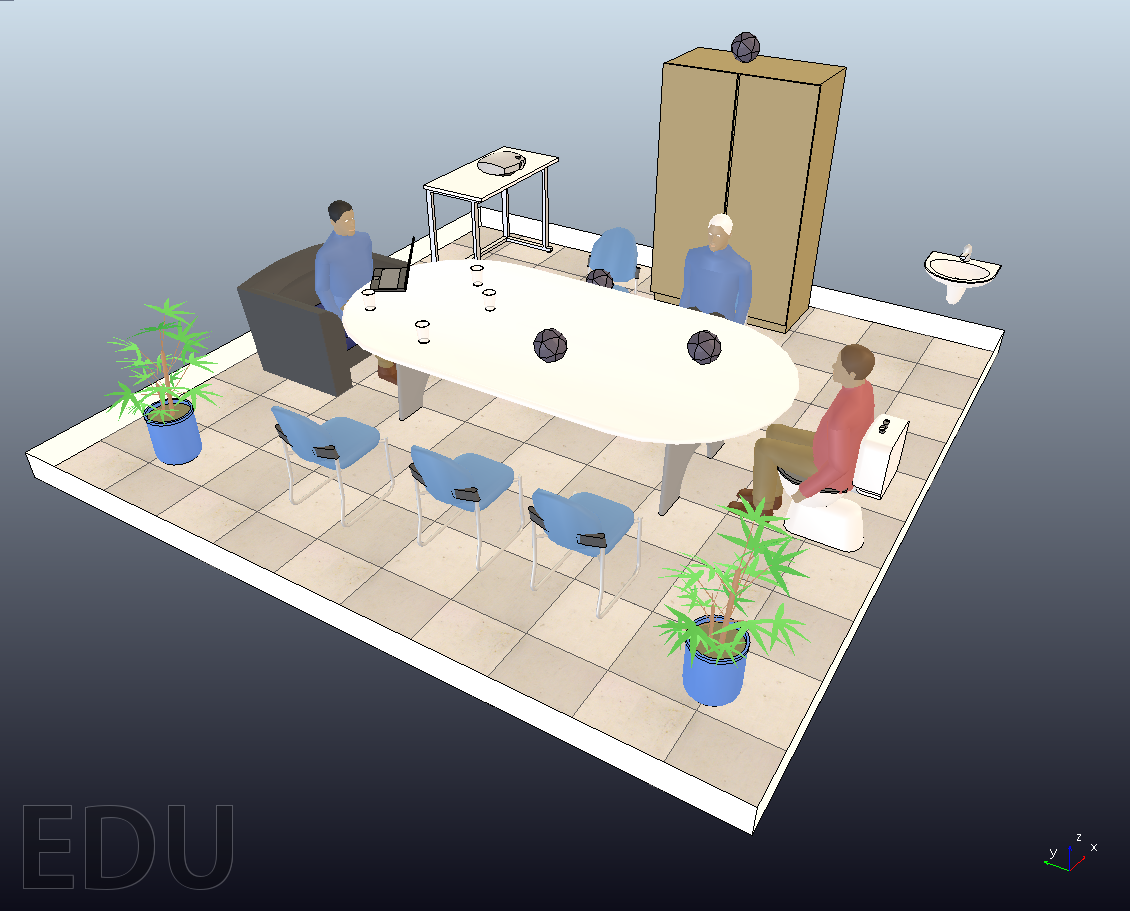

In [6]:
IPython.display.Image("images/isoview0001.png", width=800, embed=True)

Being an office in a research facility, the rooms are equipped with sensors that help the robots obtaining the required data to carry out their tasks. The office in question has an RGB-D sensor mounted on the ceiling, for example, a [Microsoft Kinect](https://en.wikipedia.org/wiki/Kinect). The sensor can be used to obtain both a regular color image of a scene, as well as what is called a depth image, where each pixel of the image encodes the distances to the camera sensor. Both images are depicted below. In the depth picture, darker, more blueish colors represent pixels that are farther away from the sensor.

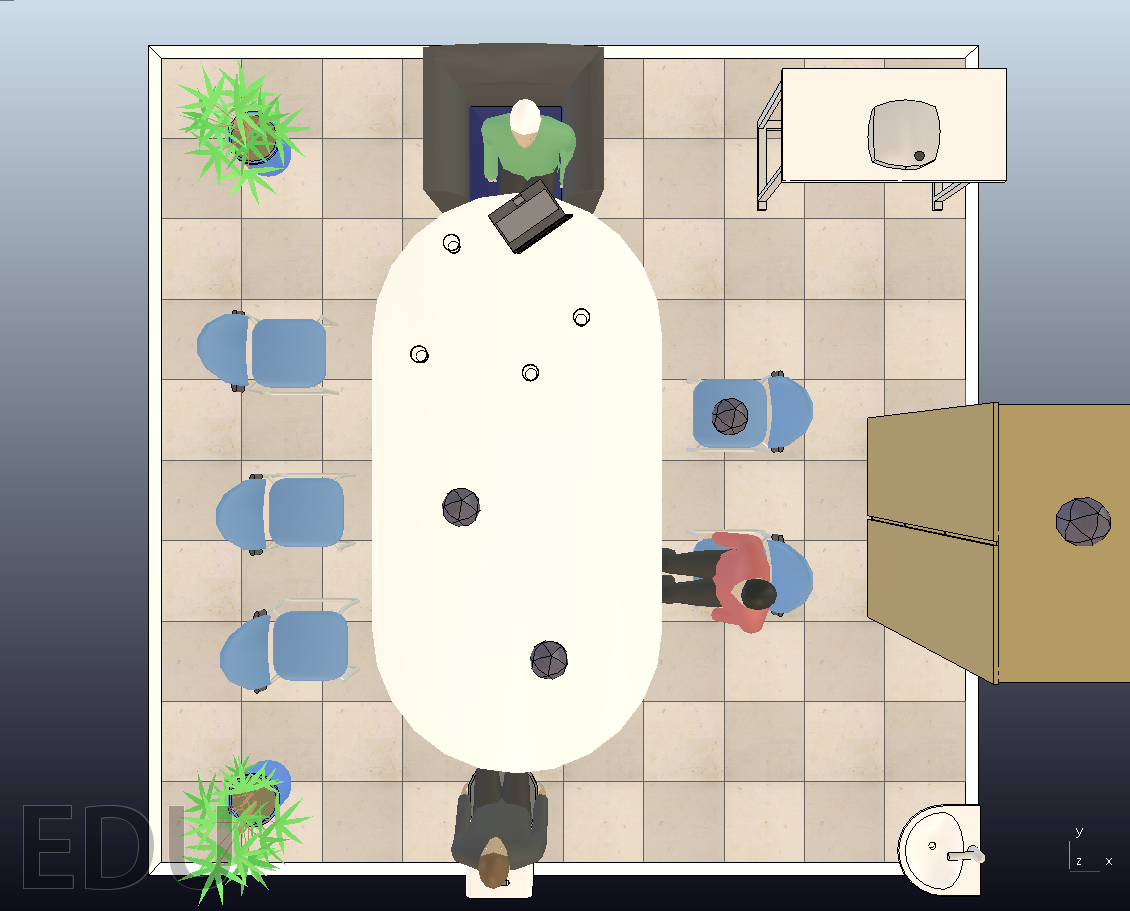

In [7]:
IPython.display.Image("images/rgb0001.png", width=800, embed=True)

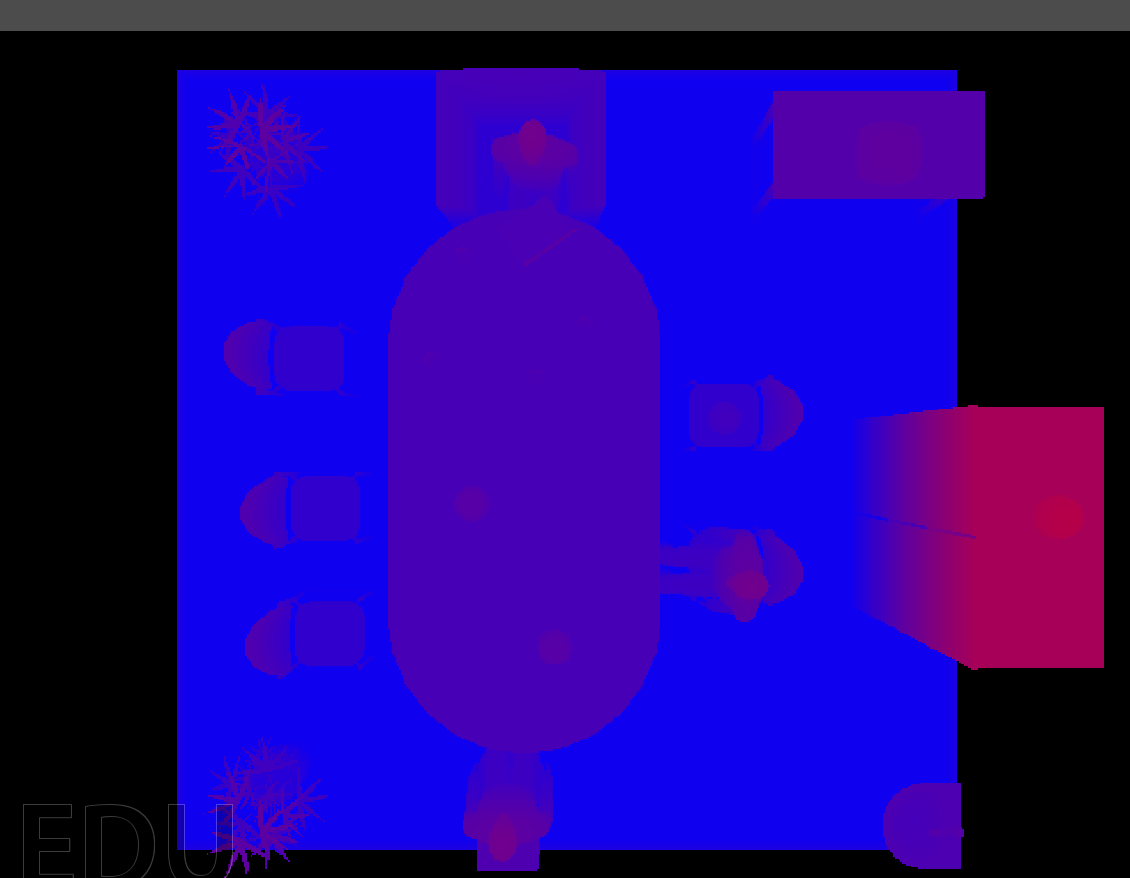

In [8]:
IPython.display.Image("images/depth0001.png", width=800, embed=True)

The Microsoft Kinect works by emitting an infrared pattern, observing the projected pattern with a camera sensor, and calculating the distance based on how the known pattern deviates from the projected pattern. The details should not concern you, just keep in mind that the Kinect and similar sensors can be used to measure the distance of each pixel in a picture. Depth images can in turn be converted into a different data format, called [*point clouds*](http://en.wikipedia.org/wiki/Point_cloud). Point clouds are nothing more than a collections of 3-component tuples where each component represents the coordinate of a given point. Formally, a common definition of a point cloud $P$ is:

$P = \{(x, y, z) \lvert x,y,z \in \mathbb{R} \}$

Typically, the reference frame has it's origin at the position of the camera sensor. Below is a picture of the aforementioned office scene as a point cloud obtained by the sensor mounted on the ceiling of the office. The unit of the points in this point cloud is in **meters**.

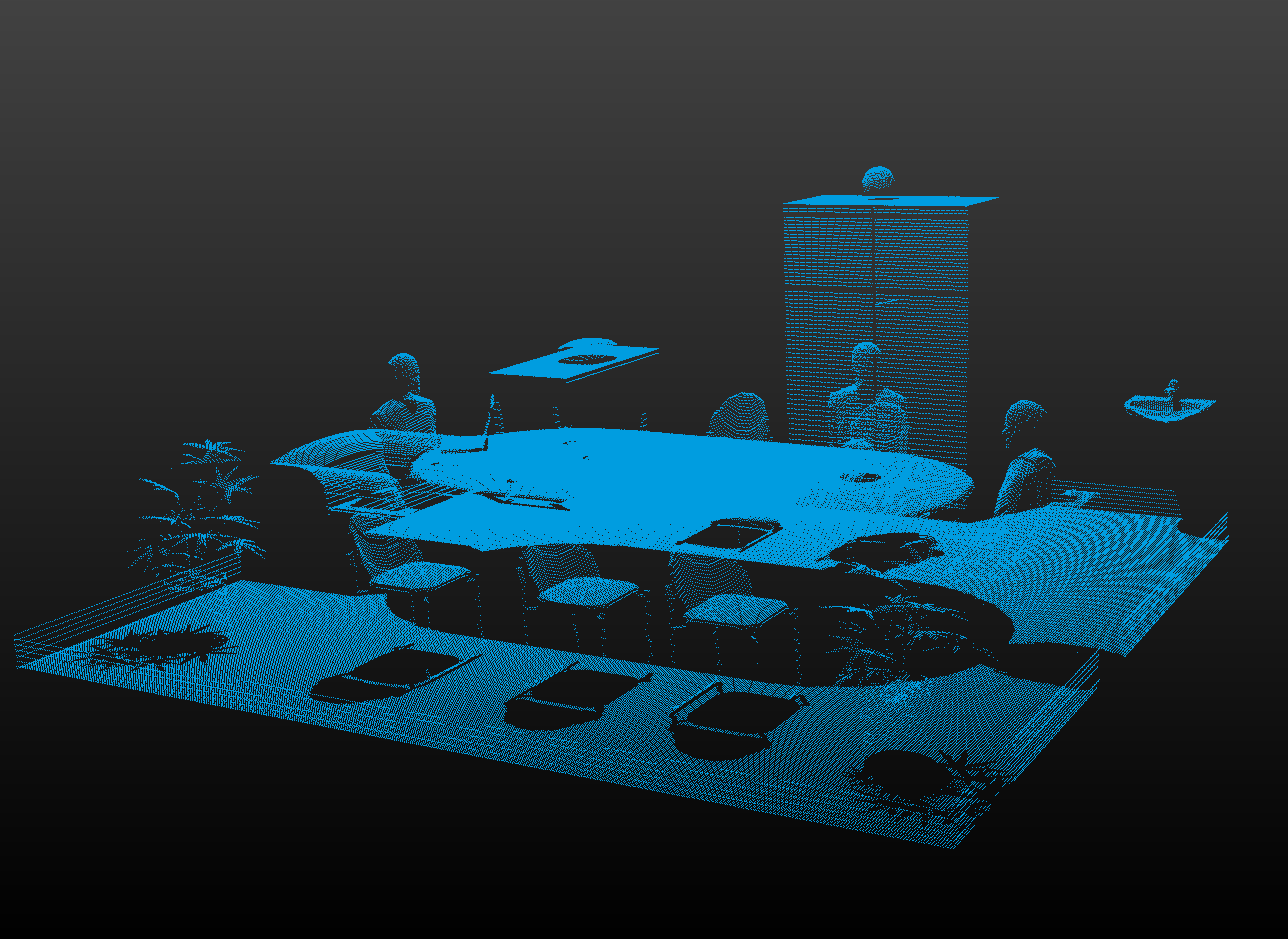

In [9]:
IPython.display.Image("images/pointcloud0001.png", width=800, embed=True)

If your browser supports WebGL and/or Adobe Flash, you can click [this link](http://www.pointclouds.org/assets/viewer/pcl_viewer.html?load=http://www.directlinkupload.com/uploads/194.95.66.1/cloud.pcd) to view the point cloud in an interactive manner. Otherwise, you can view the included *cloud.asc* or *cloud.ply* file in [MeshLab](http://meshlab.sourceforge.net/), or the included *cloud.pcd* file using *pcl_viewer*, which should be included in your ROS installation.

Note the object "shadows" in the picture above - given what you know about how the point cloud is generated, why do these shadows exist? What are those shadows really?

Now, back to our scenario. Imagine your robot has picked up the package and was informed of the desired destination location (said office) a while ago. Your robot has reached it's destination and is waiting in front of the office door. It has requested sensor data from the central logistics unit and the point cloud was transmitted to the robot. Your task is to identify possible drop points where the robot could place the package once inside the office.

In order to do that, we want to obtain a new point cloud, but associate each point with a quality measure that allows the robot to rate each point with respect to dropping off a package at that point. A simple quality measure would be the orientation of the underlying surface's [normal vector](https://en.wikipedia.org/wiki/Normal_%28geometry%29). If, for any given point, the surface of which that point is a part of is not parallel to the floor, it sure wouldn't be a wise idea to place a package there. Also, this information can be used to detect tables, shelves and other furniture items commonly used for storage, packages or otherwise.

We assume that the robot knows the world reference frame, i.e. it has an understanding of how the world is oriented. Given a fixed robot construction and a priori knowledge of the pose of the sensor used to obtain the point cloud data, this is a sensible assumption. In this case, we assume that our world reference frame is a subspace of $\mathbb{R}^3$ and that the orthonormal basis $B$ of our coordinate space is $B = \{ \begin{bmatrix}1 & 0 & 0\end{bmatrix}, \begin{bmatrix}0 & 1 & 0\end{bmatrix}, \begin{bmatrix}0 & 0 & 1\end{bmatrix} \}$.

To be able to calculate the normal vectors for each point in the point cloud, you can implement a (rather old) publication by Hoppe et al., [Surface reconstruction from unorganized points](http://research.microsoft.com/pubs/145618/recon.pdf). You don't have to study the complete paper, all relevant information is contained in paragraph **3.2 Tangent Plane Estimation** in the linked paper. In order to obtain the point neighborhoods (called *Nbhd(x)* in the paper), use a spatial partitioning structure such as [**scipy.spatial.cKDTree**](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html) and use the method **query_ball_point** with a radius of **$4cm$** and the [**L2 norm**](https://en.wikipedia.org/wiki/P-norm#The_p-norm_in_finite_dimensions) as distance measure. When doing this, mind points that yield no usable neighborhood, e.g. points that are too far away from any other given point and which will establish no neighborhood. Filter those points out and remember not to process them in the upcoming steps - you can pass **any** value for the resulting angles for these points, but do **not** omit them. Note: You don't have to understand how the kD-Tree works, just remember that it is a structure that allows you to speed up spatial neighborhood queries. If you are curious, however, there are many [resources](https://www.cs.cmu.edu/~awm/animations/kdtree/) on kD-Trees available on the web.

For each point, obtain a normal vector of it's neighborhood and calculate the angle between the normal vector and the Z-axis. The reasoning behind this notion is: for any surface to be level, it has to be parallel to the floor. Every surface parallel to the floor will have a normal vector pointing to the same direction as the Z-axis, thus the angle between the normal vector of the surface and the Z-axis is a measure of how level the surface is, and thus in turn how suitable it is for dropping of a package.

In [3]:
from scipy import spatial
import numpy.linalg as linalg
def rate_placements(point_cloud):
    x = np.loadtxt('/home/sabeeh/Desktop/MRC_A_002/data/cloud.asc')
    i= x[0:219435, ]
    tree = spatial.cKDTree(i)


    for row in range(0,219435):
        globals()['string%s' % row] = tree.query_ball_point(i[row],0.04,2)
    for row in range(0,219435):
        globals()['meanset%s' % row] = np.empty([1,3])#np.matrix([[0,0,0]])

        for internal in range(0,len(globals()['string%s' %row])):
            if(len(globals()['string%s' %row])<=1):
                pass

            else:
                globals()['meanset%s' % row] = np.vstack((globals()['meanset%s' % row],x[globals()['string%s' %row][internal]]))
        globals()['meanset%s' % row] = np.delete(globals()['meanset%s' % row],0,0)
    for j in range(0,219435):
        if((globals()['meanset%s' % j]).shape == (0,3)):
            pass
        else:
            a=globals()['meanset%s' % j].mean(0)
            globals()['x%s' % j]=np.matrix(a)

    angle = np.empty([219435])
    for row in range(0,219435):
        #globals()['n%s' %row] = np.outer(globals()['meanset%s' % row].T,globals()['meanset%s' % row])
        if((globals()['meanset%s' % j]).shape == (0,3)):
            pass
        else:
            globals()['n%s' %row] = np.cov(globals()['meanset%s' % row].T)
    angle = np.empty([219435])
    for row in range(0,219435):
        if((globals()['meanset%s' % row]).shape == (0,3)):
            pass
        else:
            (w,v) = np.linalg.eig(globals()['n%s' % row])
            mini_vector = v[:,np.argmin(w)]
            pro = mini_vector*mini_vector
            mag  = np.sqrt(np.absolute(pro[0]+pro[1]+pro[2]))
            dotproduct = np.dot(mini_vector, [0,0,1])
            #print dotproduct
            angle[row] = np.arccos(dotproduct/mag)
    return angle


/home/sabeeh/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:1890: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/sabeeh/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/sabeeh/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:69: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/sabeeh/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:1901: RuntimeWarning: invalid value encountered in true_divide
  return (dot(X, X.T.conj()) / fact).squeeze()
/home/sabeeh/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part


After having obtained a normal vector for each point in the point cloud, assign a color to that point by mapping the angle to a linearly segmented color space ranging from green to red, where green means "perfectly parallel to the ground". You can use the [matplotlib.cm](http://matplotlib.org/api/cm_api.html) module for this task. Also see: [Matplotlib Cookbook: Show Colormaps Example](http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps). Generally speaking, this step boils down to picking (or creating) a suitable colormap and applying the colormap to your angle values. Remember to convert the colors to a range of $[0, 255]$ before continuing with the next step. The following cell shows a simple example code snippet on how to apply colormaps:

In [4]:

colors = cm.RdYlGn_r(angle)

retcol = colors[:,:3] *255

final = np.append(i,retcol,axis=1)

After you have obtained color values for each point, create a new $N \times M$ matrix, where $N$ is the number of points and $M == 6$, storing the $X, Y$ and $Z$ coordinate for each point, as well as it's color values ($R , G, B$ tuple in the range $[0, 255]$). Then, pass this matrix to the following function to generate a file in the [Stanford Triangle Format](https://en.wikipedia.org/wiki/PLY_%28file_format%29).

In [5]:
def save_as_ply(filename, points):
    assert points.ndim == 2
    assert points.shape[1] == 6
    header = """ply
        format ascii 1.0
        element vertex {0}
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        element face 0
        property list uchar int vertex_indices\r\nend_header"""
    number_of_points = points.shape[0]
    with open(filename, "w") as ply_file:
        print >>ply_file, header.format(number_of_points)
        point_format = ("%.18f", "%.18f", "%.18f", "%d", "%d", "%d") 
        np.savetxt(ply_file, points, delimiter=" ", fmt=point_format)
        
save_as_ply("output.ply",final)

You can visualize your generated point cloud file using Meshlab or by using the command line utility **pcl_ply2pcd** and opening the resulting file in **pcl_viewer**. Both utilities come with an installation of PCL and should be included in your ROS installation.

Your solution should looks similar to this.

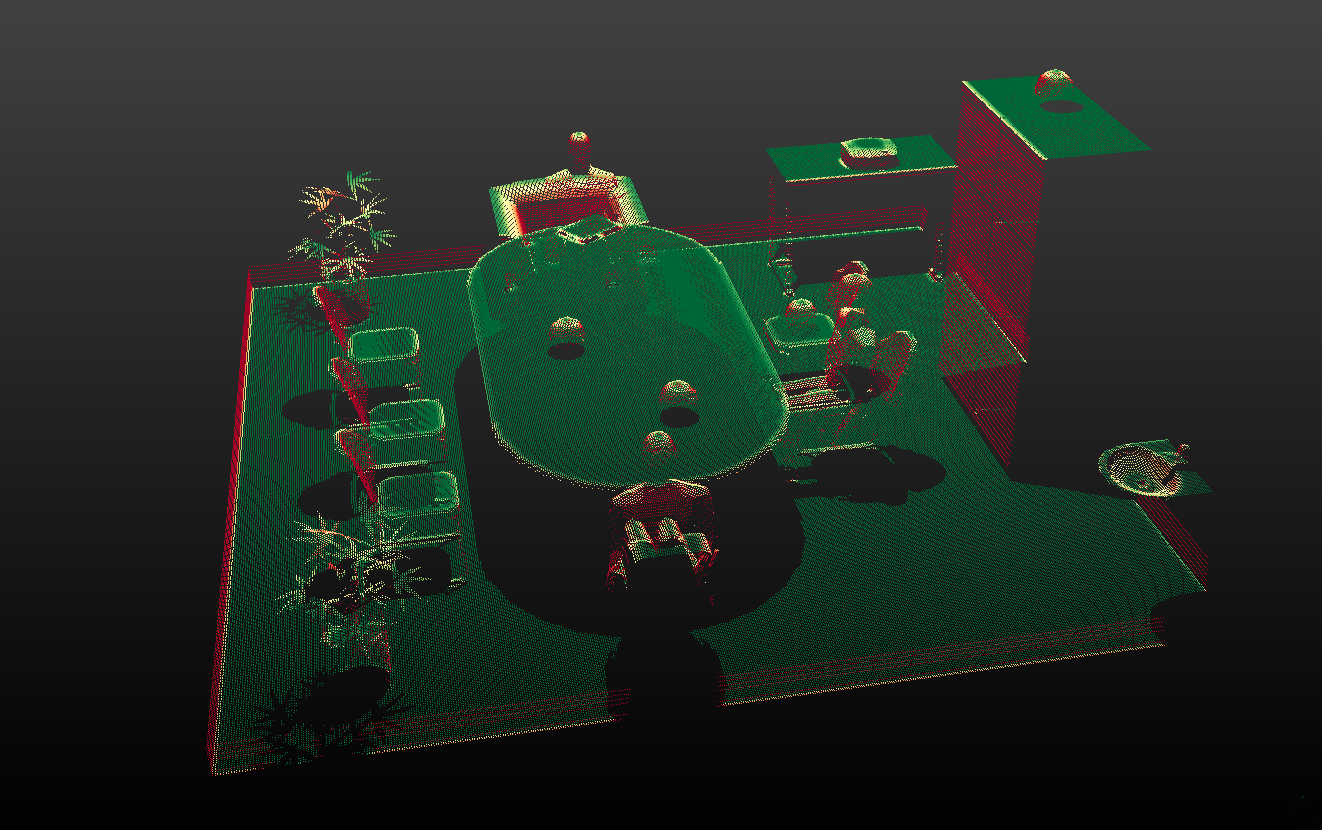

In [14]:
IPython.display.Image("images/result0001.png", width=800, embed=True)